Aakash Sarraf

## Imports

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
# Define the invTrans function
def invTrans(img):
    return 255 * img

## Dataset

In [118]:
TRAIN_DIR = "/kaggle/input/rgb_2_thermal/train/train"
VAL_DIR = "/kaggle/input/rgb_2_thermal/val/val"

In [119]:
class rgb2thermal_Dataset(Dataset):
    def __init__(self, 
                 base_path, 
                 transform=transforms.Compose([transforms.ToTensor()]),
                 isTrain=False):
        self.base_path = base_path
        self.rgb_imgNames = sorted(os.listdir(os.path.join(base_path, "rgb")))
        self.thermal_imgNames = sorted(os.listdir(os.path.join(base_path, "thermal")))
        
        self.isTrain = isTrain
        self.transform = transform
        
    
    def __getitem__(self, idx):
        rgb_imName = self.rgb_imgNames[idx]
        thermal_imName = self.thermal_imgNames[idx]
        
        rgb = Image.open(os.path.join(self.base_path, "rgb",  rgb_imName))
        thermal = Image.open(os.path.join(self.base_path, "thermal", thermal_imName))
        
        rgb_tf = self.transform(rgb)
        thermal_tf = self.transform(thermal)
        
        return {"rgb": rgb_tf, "thermal": thermal_tf, "fileName": rgb_imName} 
    
    
    def __len__(self):
        return len(self.rgb_imgNames)

### Transforms

In [120]:
transform = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor(),
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [121]:
train_data = rgb2thermal_Dataset(TRAIN_DIR, transform, isTrain=True)
val_data = rgb2thermal_Dataset(VAL_DIR, transform)

## DataLoaders

In [122]:
trainLoader = DataLoader(train_data, shuffle=True, batch_size=16)
valLoader = DataLoader(val_data, shuffle=False, batch_size=16)

### Sanity Visualizations

In [123]:
def show(img):
    npimg = img.numpy()
    plt.axis(False)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

**Note: Normalized images always look darker!**    


Try commenting out the normalization transform to see your actual images, as is

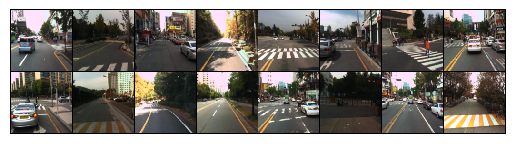

In [124]:
out = next(iter(trainLoader))
show(torchvision.utils.make_grid(out['rgb'], nrow=8))

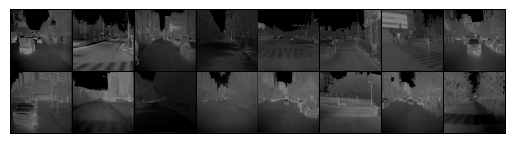

In [125]:
show(torchvision.utils.make_grid(out['thermal'], nrow=8))

## Model: ResNet-18 U-Net 



In [126]:
!pip install -Uqq segmentation-models-pytorch

In [127]:
import segmentation_models_pytorch as smp

In [128]:
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=3,                      # model output channels (number of classes in your dataset)
    decoder_use_batchnorm=True,
)

## Config

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [130]:
EPOCHS = 5
val_after_every = 2


## Optimizer & Losses

In [131]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(trainLoader))
loss = nn.SmoothL1Loss()

## Train-Val Spaghetti

In [132]:
model.to(device)
loss.to(device)

SmoothL1Loss()

In [133]:
overall_valid_loss = np.inf

for epoch in range(EPOCHS):
    ### Train
    model.train()
    train_loss = 0
    for i, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        inp_rgb = batch['rgb'].to(device)
        tar_thermal = batch['thermal'].to(device)
        
        out = model(inp_rgb)

        loss_this = loss(out, tar_thermal)
        loss_this.backward()
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss_this.item()
    train_loss /= len(trainLoader)
    print(f"EPOCH: {epoch + 1}, train_loss: {train_loss}")
    
    ### Validation
    if (epoch + 1) % val_after_every == 0:
#         print("Validating...")
        model.eval()
        valid_loss = 0
        
        for data in valLoader:
            img, thermal, fName = data['rgb'], data['thermal'], str(data['fileName'][0]).strip()
            img = img.to(device)
            thermal = thermal.to(device)

            outputs = model(img).detach()
            inv_tensor = invTrans(outputs).cpu().numpy()[0].transpose(1, 2, 0)

            # Save the regenerated thermal image
            cv2.imwrite(f"/kaggle/working/predictions/{fName}", inv_tensor)

            # Save the original thermal image
            original_thermal = thermal.cpu().numpy()[0].transpose(1, 2, 0)
            cv2.imwrite(f"/kaggle/working/original_thermal/{fName}", original_thermal)

EPOCH: 1, train_loss: 0.08195812989115006
EPOCH: 2, train_loss: 0.005142243142934546
EPOCH: 3, train_loss: 0.004175858069506902
EPOCH: 4, train_loss: 0.003479856824029296
EPOCH: 5, train_loss: 0.0032063046071146217


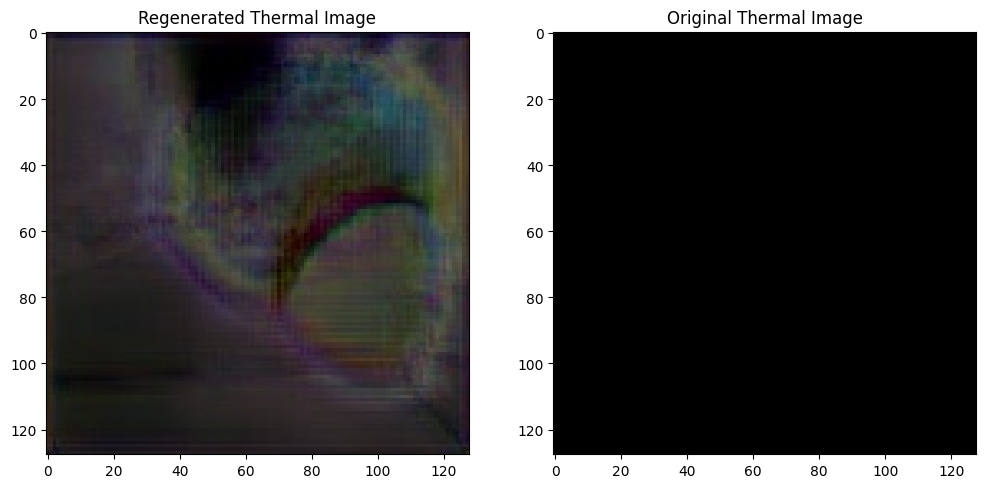

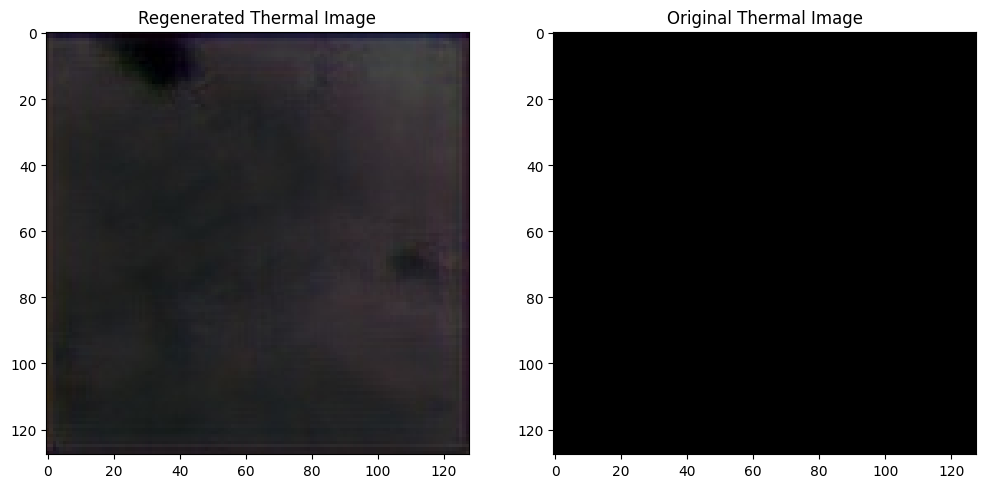

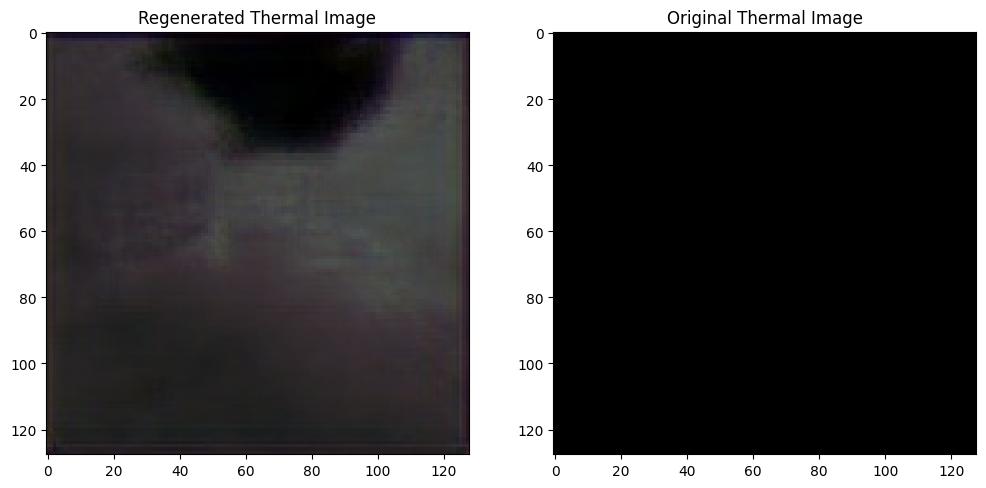

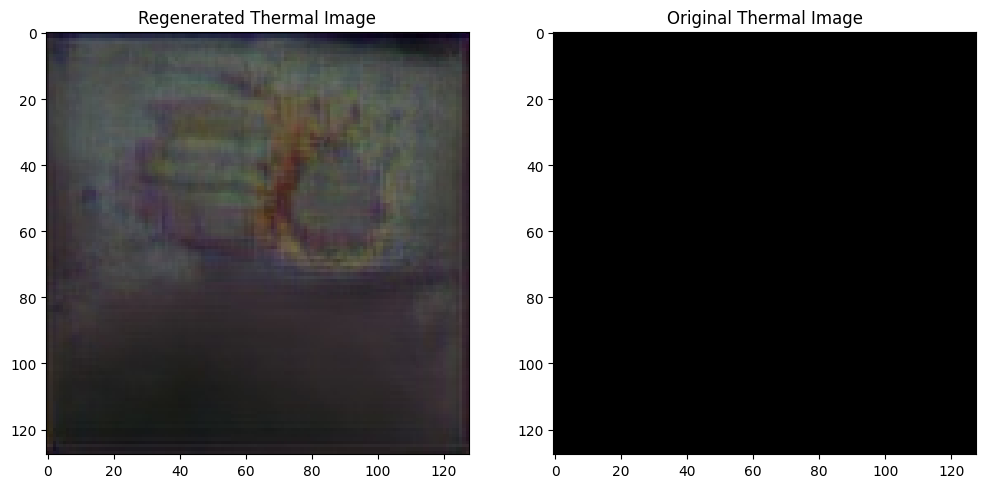

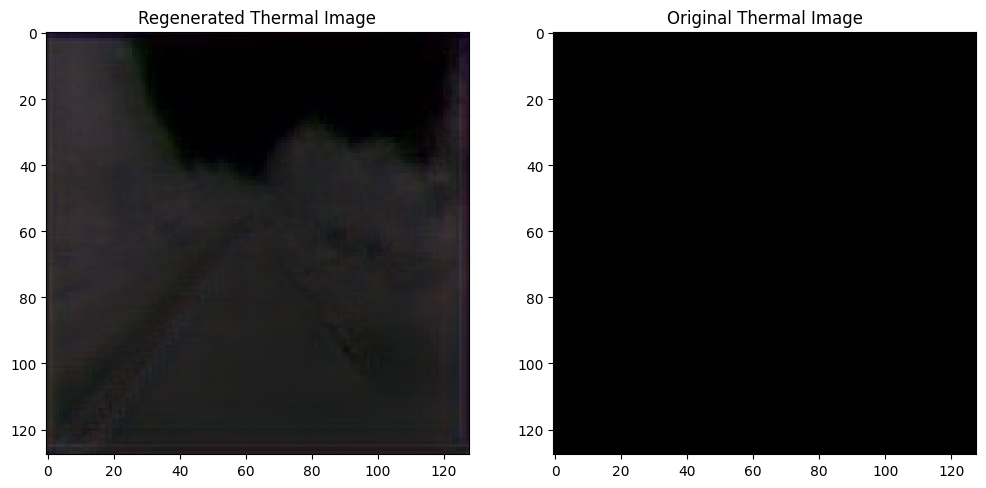

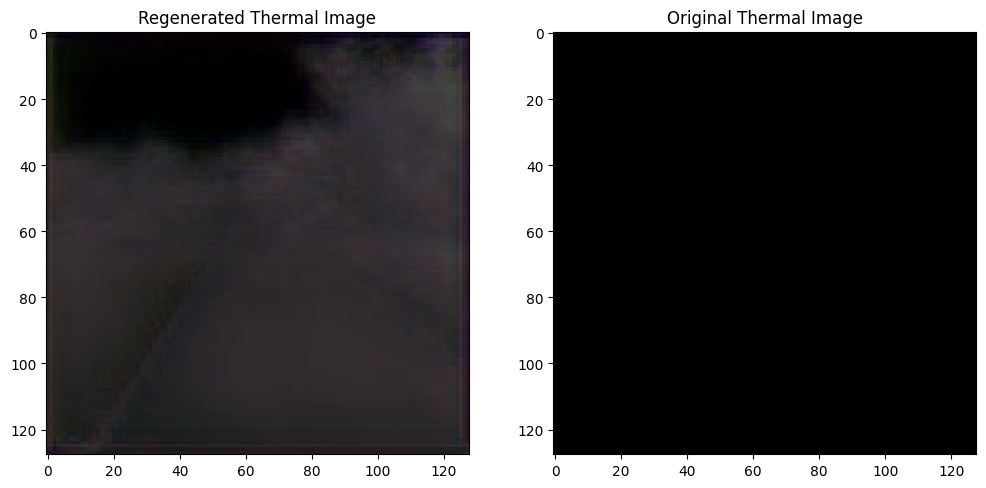

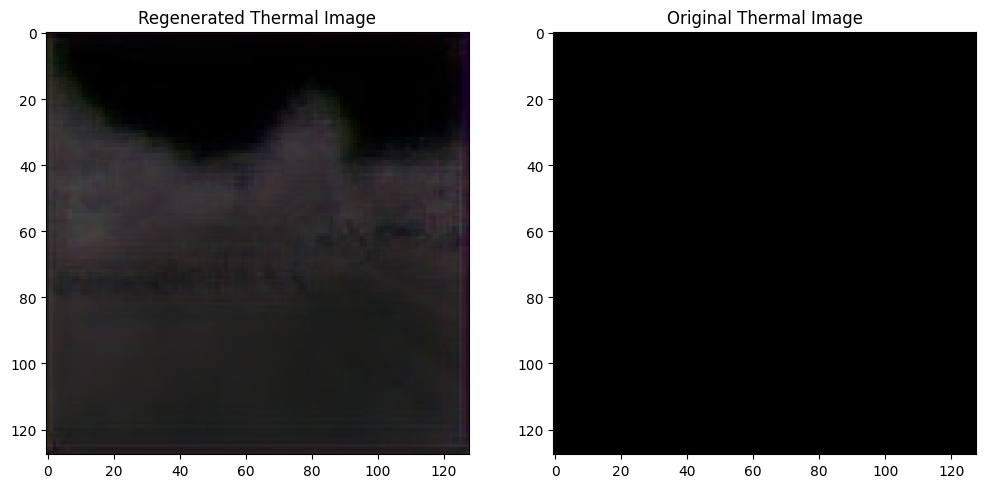

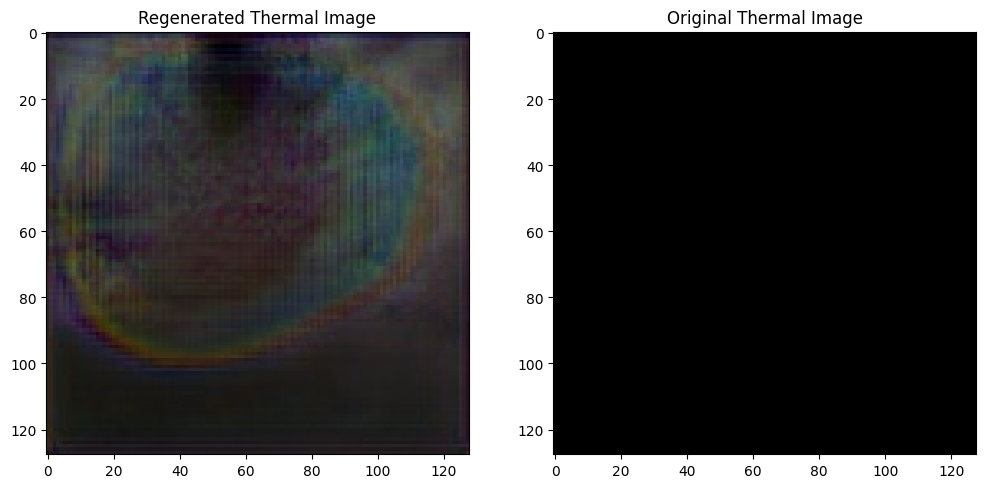

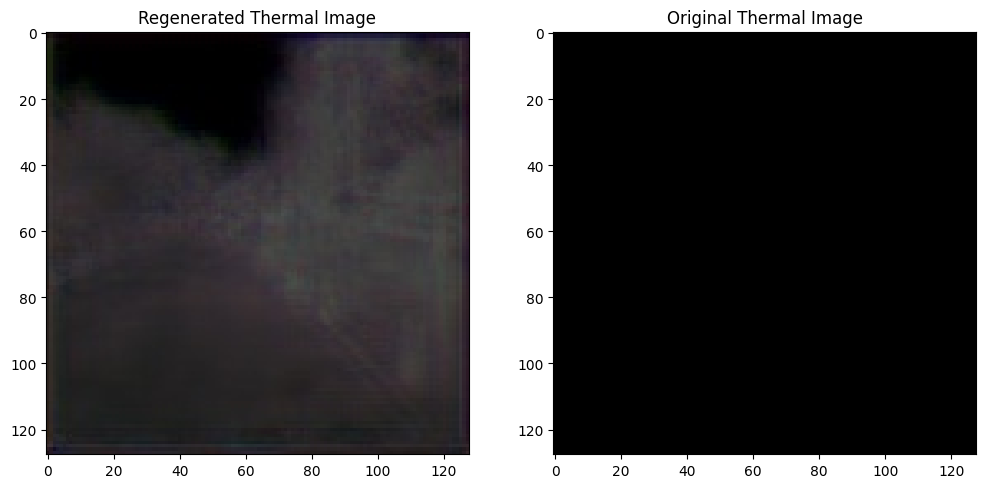

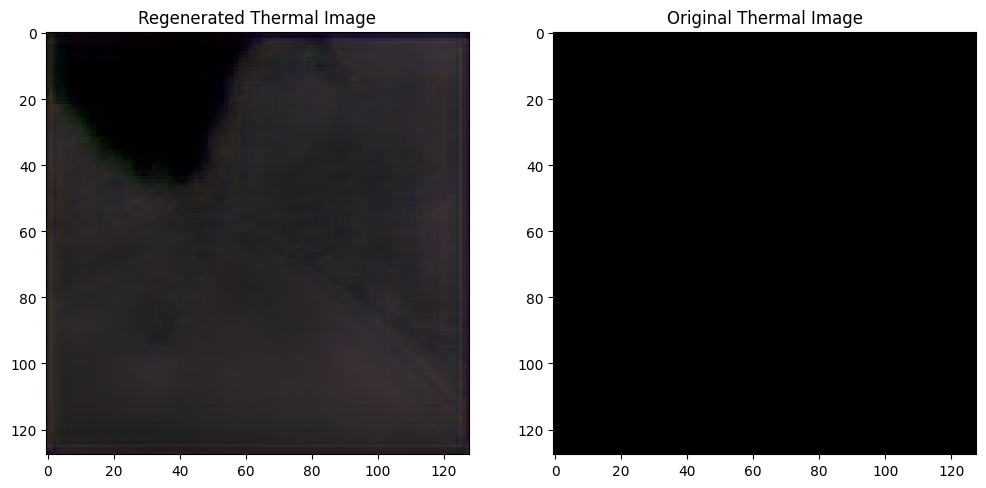

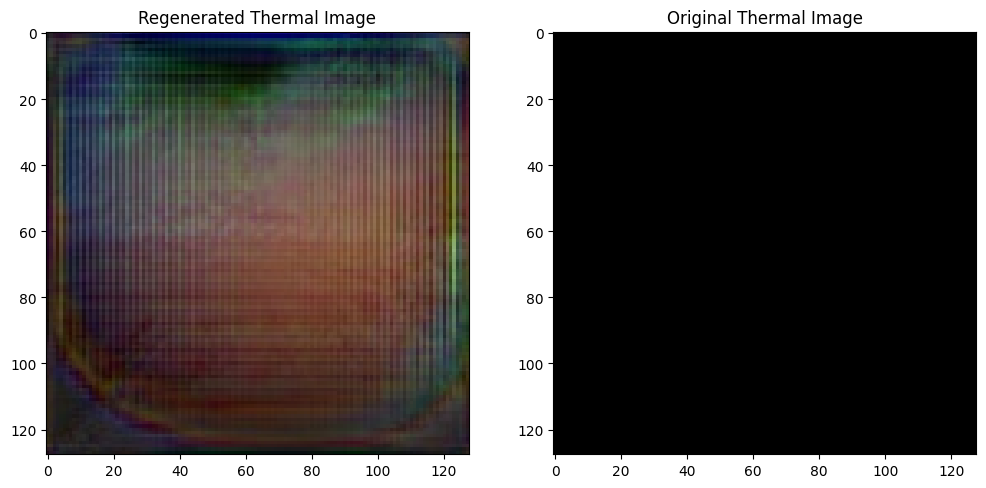

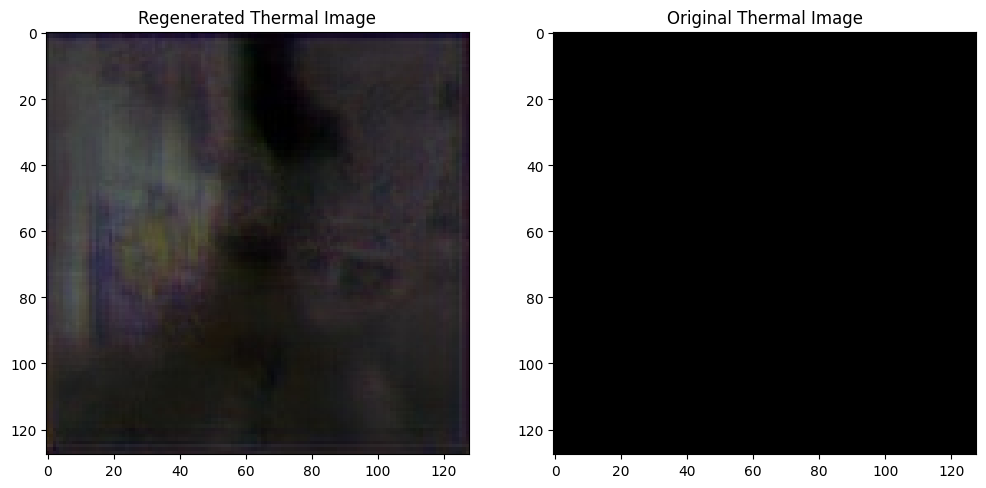

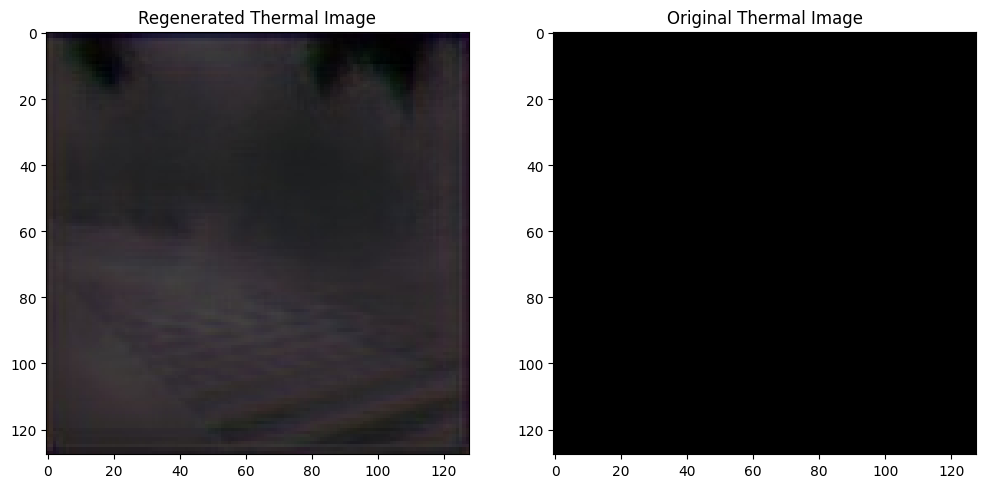

In [134]:
import os
import cv2
# Define the paths for regenerated and original images
regenerated_dir = "/kaggle/working/predictions"
original_dir = "/kaggle/working/original_thermal"

# Create the directories if they don't exist
os.makedirs(regenerated_dir, exist_ok=True)
os.makedirs(original_dir, exist_ok=True)

# Get the list of regenerated images
regenerated_images = os.listdir(regenerated_dir)

# Visualize the images
for image_name in regenerated_images:
    # Load regenerated and original images
    regenerated_image = cv2.imread(os.path.join(regenerated_dir, image_name))
    original_image = cv2.imread(os.path.join(original_dir, image_name))

    # Normalize the pixel values to match the regenerated image
    cv2.normalize(original_image, original_image, 0, 255, cv2.NORM_MINMAX)

    # Display the normalized original image
    #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    
    # Create a plot with two subplots (side by side)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Regenerated Thermal Image")
    plt.imshow(cv2.cvtColor(regenerated_image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Original Thermal Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

    plt.show()

## Creating submission.csv 

**NOTE: Your notebook should ouput a submission.csv file(in the working directory) with 2 columns: ID and RMImg**

The working-code below generates one. Please feel free to use it as a template

In [135]:
!mkdir predictions

mkdir: cannot create directory ‘predictions’: File exists


For saving...

In [136]:
def invTrans(img):
    return 255 * img

### Load best saved model >> Validate per Image >> Store in dir

In [137]:
ckpts = sorted([x for x in os.listdir(os.getcwd()) if x.endswith(".pth")])
best_ckpt = ckpts[-1]

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=3,                      # model output channels (number of classes in your dataset)
    decoder_use_batchnorm=True,
)
model.load_state_dict(torch.load(os.path.join(os.getcwd(), best_ckpt), map_location="cpu"))
model.to(device)

valLoader2 = DataLoader(val_data, shuffle=False, batch_size=1)

model.eval()
for data in tqdm(valLoader2):
    img, thermal, fName = data['rgb'], data['thermal'], str(data['fileName'][0]).strip()
#     print(fName, len(fName))
    img = img.to(device)
    thermal = thermal.to(device)
        
    outputs = model(img).detach()
    inv_tensor = invTrans(outputs).cpu().numpy()[0].transpose(1,2,0)
#     print(inv_tensor.shape)
    cv2.imwrite(f"/kaggle/working/predictions/{fName}", inv_tensor)

IndexError: list index out of range

### Row Major Encoding (DO NOT CHANGE!)

In [ ]:
# To convert images to Row-Major Format
def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(img[k][j][i])  
    return lst

### Bim Bim Boom Bam ;)

In [ ]:
# Creating a submission.csv
BASE = "/kaggle/working/predictions" # wherever you save predictions OR if you have a prediction list use it directly)
val_rgb_lst = os.listdir(BASE)
subDict = {"ID":[], "RMImg": []}

for im_name in tqdm(val_rgb_lst):
    img = cv2.imread(os.path.join(BASE, im_name))
    rme_img = row_major_enc(img)
    
    subDict["ID"].append(im_name)
    subDict["RMImg"].append(rme_img)
    
subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]], 
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("submission.csv", index=False)

In [ ]:
!rm -rf predictions/*.jpg *.pth